In [1]:
!pip install missingno catboost

In [2]:
import pandas as pd
import datetime
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

from typing import List, Tuple

import missingno as msno

from catboost import CatBoostClassifier

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(color_codes=True)
sns.set()
sns.set_palette('husl')


pd.options.display.max_rows=100
pd.options.display.max_columns=400

In [3]:
train = pd.read_csv('data/assignment_train.csv')
test = pd.read_csv('data/assignment_test.csv')

In [4]:
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 150.3+ MB


In [6]:
train.duplicated().sum()

0

In [7]:
test.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3062000,0,1643492,41.0,W,9500,321.0,150.0,visa,226.0,debit,126.0,87.0,NaN,NaN,aol.com,NaN,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,50.0,2.0,104.0,104.0,0.0,317.0,0.0,NaN,NaN,NaN,NaN,317.0,NaN,NaN,NaN,NaN,317.0,NaN,NaN,NaN,M1,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,43.0,22.0,4.0,40.0,20.0,0.0,3.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,194.0,2168.0,1139.0,194.0,1965.5,991.0,0.0,202.5,148.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,20.0,0.0,0.0,0.0,4.0,44.0,0.0,20.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,194.0,2172.0,991.0,194.0,2172.0,0.0,991.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3062001,1,1643513,161.0,W,6668,390.0,150.0,mastercard,224.0,debit,325.0,87.0,55.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,T,T,F,M0,T,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Columns: 394 entries, TransactionID to V339
dtypes: float64(376), int64(4), object(14)
memory usage: 225.4+ MB


In [9]:
test.duplicated().sum()

0

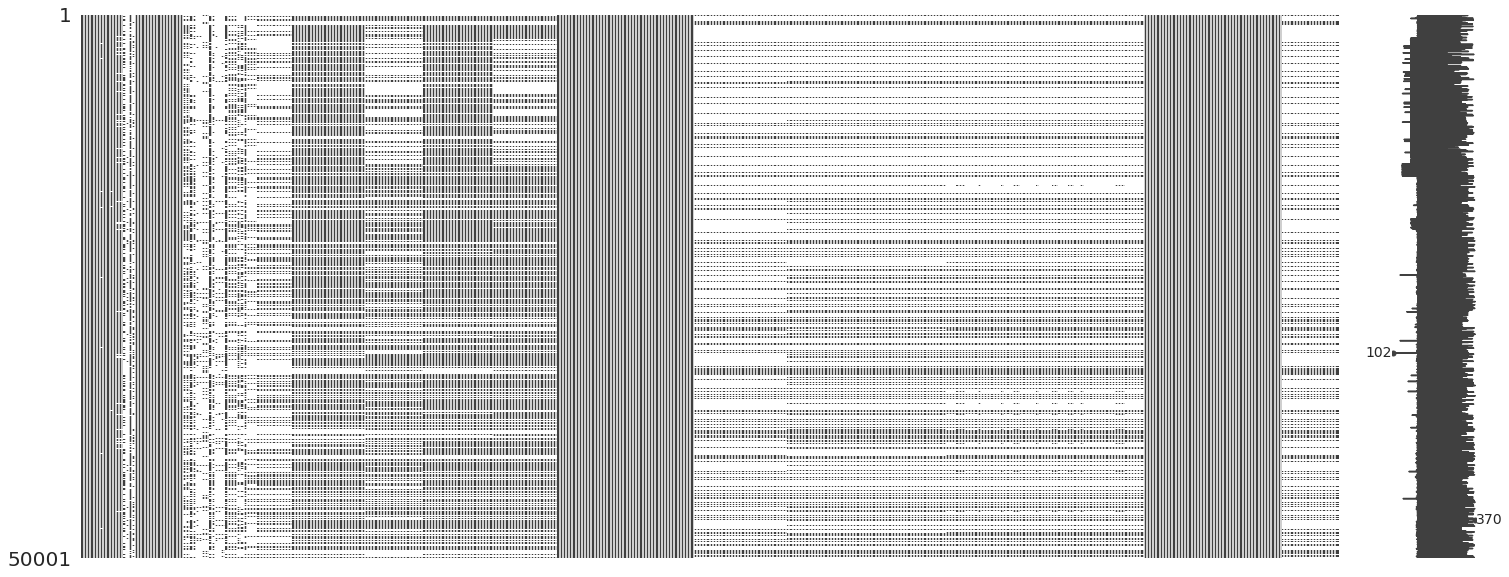

In [10]:
msno.matrix(train)

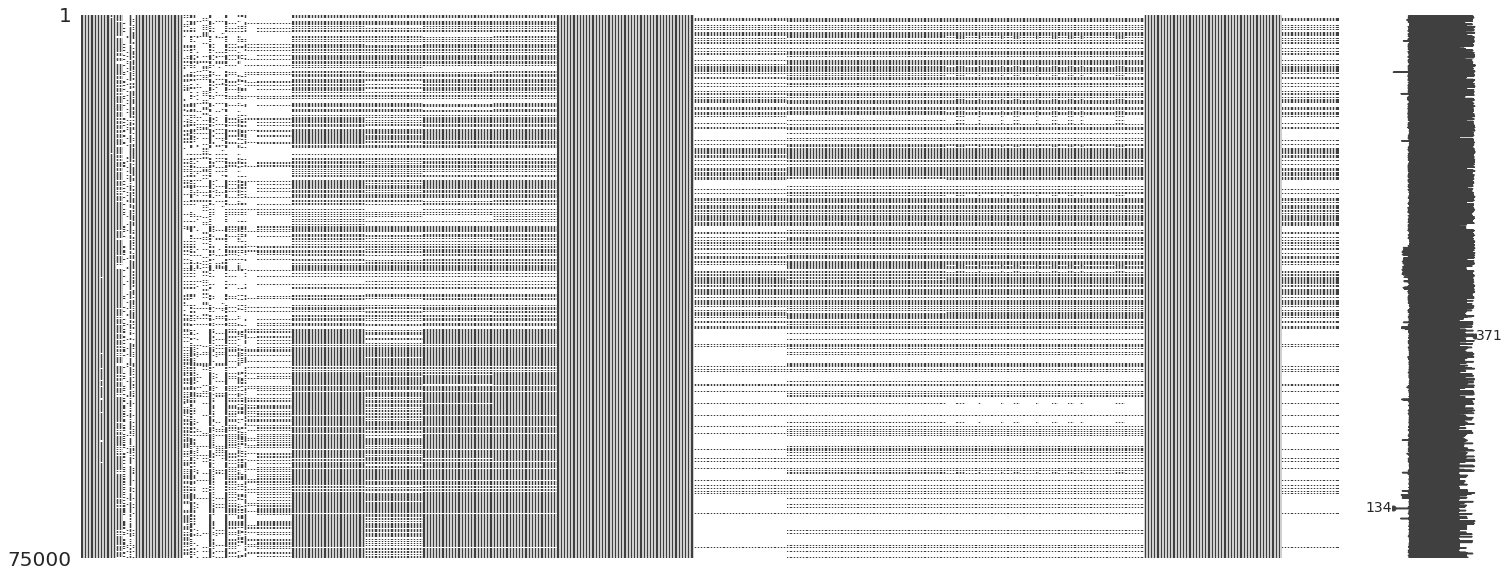

In [11]:
msno.matrix(test)

Много пропусков. Признаки с большим количесвом отсутствующих значений наверное лучше удалить

In [12]:
features_with_gaps = train.columns[train.isnull().sum() / len(train) * 100 > 50].tolist()
len(features_with_gaps)

192

In [13]:
train = train.drop(columns=features_with_gaps)
test = test.drop(columns=features_with_gaps)

### Количественные признаки

In [14]:
quant_feats = train.select_dtypes('int64').drop(columns=['TransactionID', 'isFraud']).columns.tolist()
quant_feats

['TransactionDT', 'card1']

In [15]:
train[quant_feats].nunique().sort_values()

card1             5446
TransactionDT    48346
dtype: int64

#### Количественные признаки не имеют пропусков. TransactionDT - это время транзакции, удалим его.

In [16]:
quant_feats = ['card1']

### Категориальные признаки

In [17]:
cat_feats = train.select_dtypes('object').columns.tolist()
cat_feats

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M6']

In [18]:
train[cat_feats].nunique().sort_values()

M6                2
card4             4
card6             4
ProductCD         5
P_emaildomain    59
dtype: int64

In [19]:
train['M6'].value_counts(), train['M6'].isnull().sum()

(F    17030
 T    14300
 Name: M6, dtype: int64, 18671)

In [20]:
train['M6'].fillna(-1, inplace=True)
train.loc[train['M6'] == 'T', 'M6'] = 1
train.loc[train['M6'] == 'F', 'M6'] = 0

In [21]:
test['M6'].fillna(-1, inplace=True)
test.loc[test['M6'] == 'T', 'M6'] = 1
test.loc[test['M6'] == 'F', 'M6'] = 0

In [22]:
train['P_emaildomain'].value_counts(), train['P_emaildomain'].isnull().sum()

(gmail.com           17910
 yahoo.com            8360
 hotmail.com          3728
 anonymous.com        3466
 aol.com              2443
 comcast.net           849
 icloud.com            468
 msn.com               387
 outlook.com           360
 att.net               326
 sbcglobal.net         307
 verizon.net           288
 live.com              247
 ymail.com             184
 bellsouth.net         182
 cox.net               157
 charter.net           141
 me.com                134
 yahoo.com.mx          126
 optonline.net         104
 live.com.mx            71
 rocketmail.com         59
 earthlink.net          55
 gmail                  41
 roadrunner.com         38
 mail.com               38
 mac.com                37
 juno.com               33
 embarqmail.com         33
 windstream.net         32
 twc.com                30
 web.de                 29
 frontier.com           28
 cfl.rr.com             24
 netzero.com            24
 frontiernet.net        24
 prodigy.net.mx         23
 

In [23]:
train.loc[~
    ((train['P_emaildomain'] == 'gmail.com') | 
    (train['P_emaildomain'] == 'yahoo.com') | 
    (train['P_emaildomain'] == 'hotmail.com') | 
    (train['P_emaildomain'] == 'anonymous.com') |
    (train['P_emaildomain'] == 'aol.com')), 'P_emaildomain'] = 'other'

In [24]:
test.loc[~
    ((test['P_emaildomain'] == 'gmail.com') | 
    (test['P_emaildomain'] == 'yahoo.com') | 
    (test['P_emaildomain'] == 'hotmail.com') | 
    (test['P_emaildomain'] == 'anonymous.com') |
    (test['P_emaildomain'] == 'aol.com')), 'P_emaildomain'] = 'other'

In [25]:
train['P_emaildomain'].fillna('missing', inplace=True)
test['P_emaildomain'].fillna('missing', inplace=True)

In [26]:
train['P_emaildomain'].value_counts()

gmail.com        17910
other            14094
yahoo.com         8360
hotmail.com       3728
anonymous.com     3466
aol.com           2443
Name: P_emaildomain, dtype: int64

### Вещественные признаки

In [27]:
float_feats = train.select_dtypes('float64').columns.tolist()
len(float_feats)

193

In [28]:
train_nunique = train[float_feats].apply(lambda x: x.nunique(dropna=False))
train_nunique.shape

(193,)

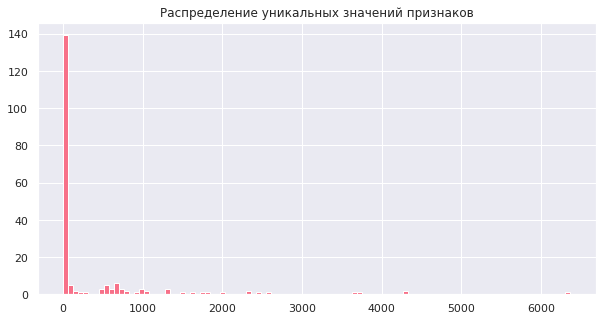

In [29]:
plt.title("Распределение уникальных значений признаков");
train_nunique.hist(bins=100, figsize=(10, 5));

In [30]:
all_features = set(train_nunique.index.tolist())
len(all_features)

193

### Константные признаки

In [31]:
const_feats = set(train_nunique[train_nunique == 1].index.tolist())
const_feats

{'V107'}

In [32]:
train.loc[:5, 'V107'], test.loc[:5, 'V107']

(0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 Name: V107, dtype: float64, 0    1.0
 1    1.0
 2    1.0
 3    1.0
 4    1.0
 5    1.0
 Name: V107, dtype: float64)

In [33]:
train['V107'].isnull().sum()

0

Константные признаки не будем использовать

### Числовые признаки

In [34]:
num_feats = (train[float_feats].fillna(0).astype(int).sum() - train[float_feats].fillna(0).sum()).abs()
num_feats = set(num_feats[num_feats > 0].index.tolist())
len(num_feats)

29

In [35]:
other = all_features - (num_feats | const_feats)
len(other)

163

### Бинарные признаки

In [36]:
bin_feats = set(train[float_feats].loc[:, other].columns[(
                      (train[float_feats].loc[:, other].max() == 1) & \
                      (train[float_feats].loc[:, other].min() == 0) & \
                      (train[float_feats].loc[:, other].isnull().sum() == 0))])
len(bin_feats)

0

In [37]:
num_feats = num_feats | other

In [38]:
other = other - num_feats
len(other)

0

### Есть четыре типа данных в наших выборках: целочисленные, категориальные, вещественые и константные.

In [39]:
train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

### Задание 1:

Построить график распределения времени совершения транзакции для обучающей / тестовой выборки, сделать выводы о том, как разбиты данные и какие виды валидации могут подойти для данной задачи.



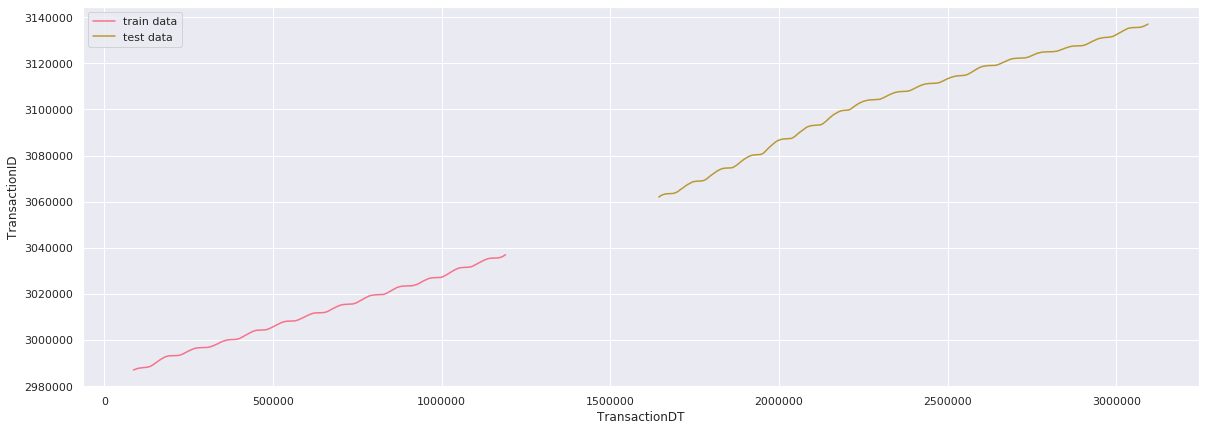

In [40]:
plt.figure(figsize=(20, 7))
plt.xlabel('TransactionDT')
plt.ylabel('TransactionID')
plt.plot(train['TransactionDT'], train['TransactionID'], label='train data' )
plt.plot(test['TransactionDT'], test['TransactionID'], label='test data')
plt.legend()
plt.show()

Модель обучалась на более ранних данных, транзакции разные.

### Задание 2:

построить scatter-plot зависимости суммы транзакции от времени совершения транзакции. Построить графики для обучающей выборки и для тестовой выборки, для обучающей выборки - построить как для целевой переменной = 0, так и для переменной = 1. Сделать выводы.

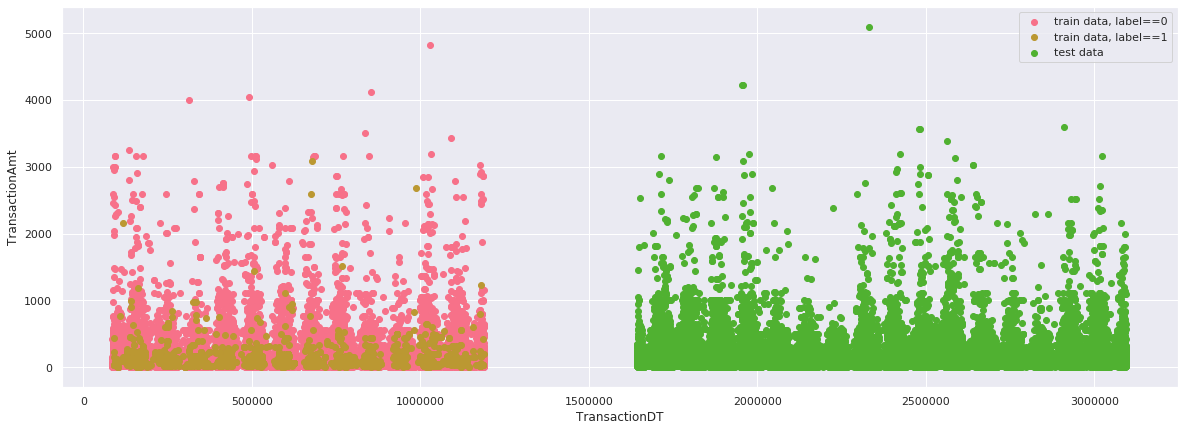

In [41]:
train_t0 = train.loc[train['isFraud'] == 0]
train_t1 = train.loc[train['isFraud'] == 1]
plt.figure(figsize=(20, 7))
plt.xlabel('TransactionDT')
plt.ylabel('TransactionAmt')
plt.scatter(train_t0['TransactionDT'], train_t0['TransactionAmt'], label='train data, label==0')
plt.scatter(train_t1['TransactionDT'], train_t1['TransactionAmt'], label='train data, label==1')
plt.scatter(test['TransactionDT'], test['TransactionAmt'], label='test data')
plt.legend()
plt.show()

### Задание 3:

построить распределение признака TransactionAmt в логарифмическом масштабе, сделать выводы о близости распредления к нормальному распределению. Построить распределение признака в логарифмическому масштабе для обучающей выборк и для тестовой выборки, сделать выводы.

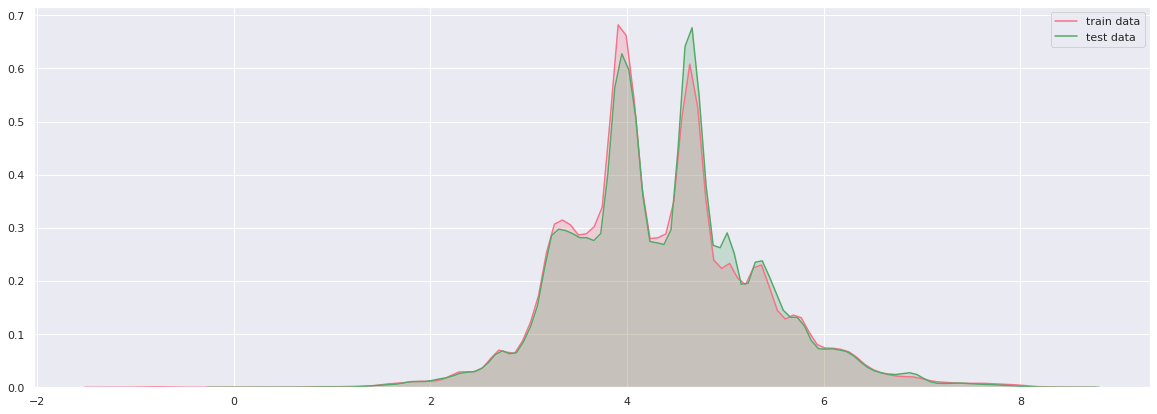

In [42]:
plt.figure(figsize=(20, 7))
sns.kdeplot(np.log(train['TransactionAmt']), shade=True, label='train data')
sns.kdeplot(np.log(test['TransactionAmt']), shade=True, label='test data', color='g')
plt.legend()
plt.show()

Распределение признака не нормальное

### Задание 4:

построить распределение признака целевой переменной в зависимости от значений категориальных признаков ProductCD, card4, card6. Сделать выводы.

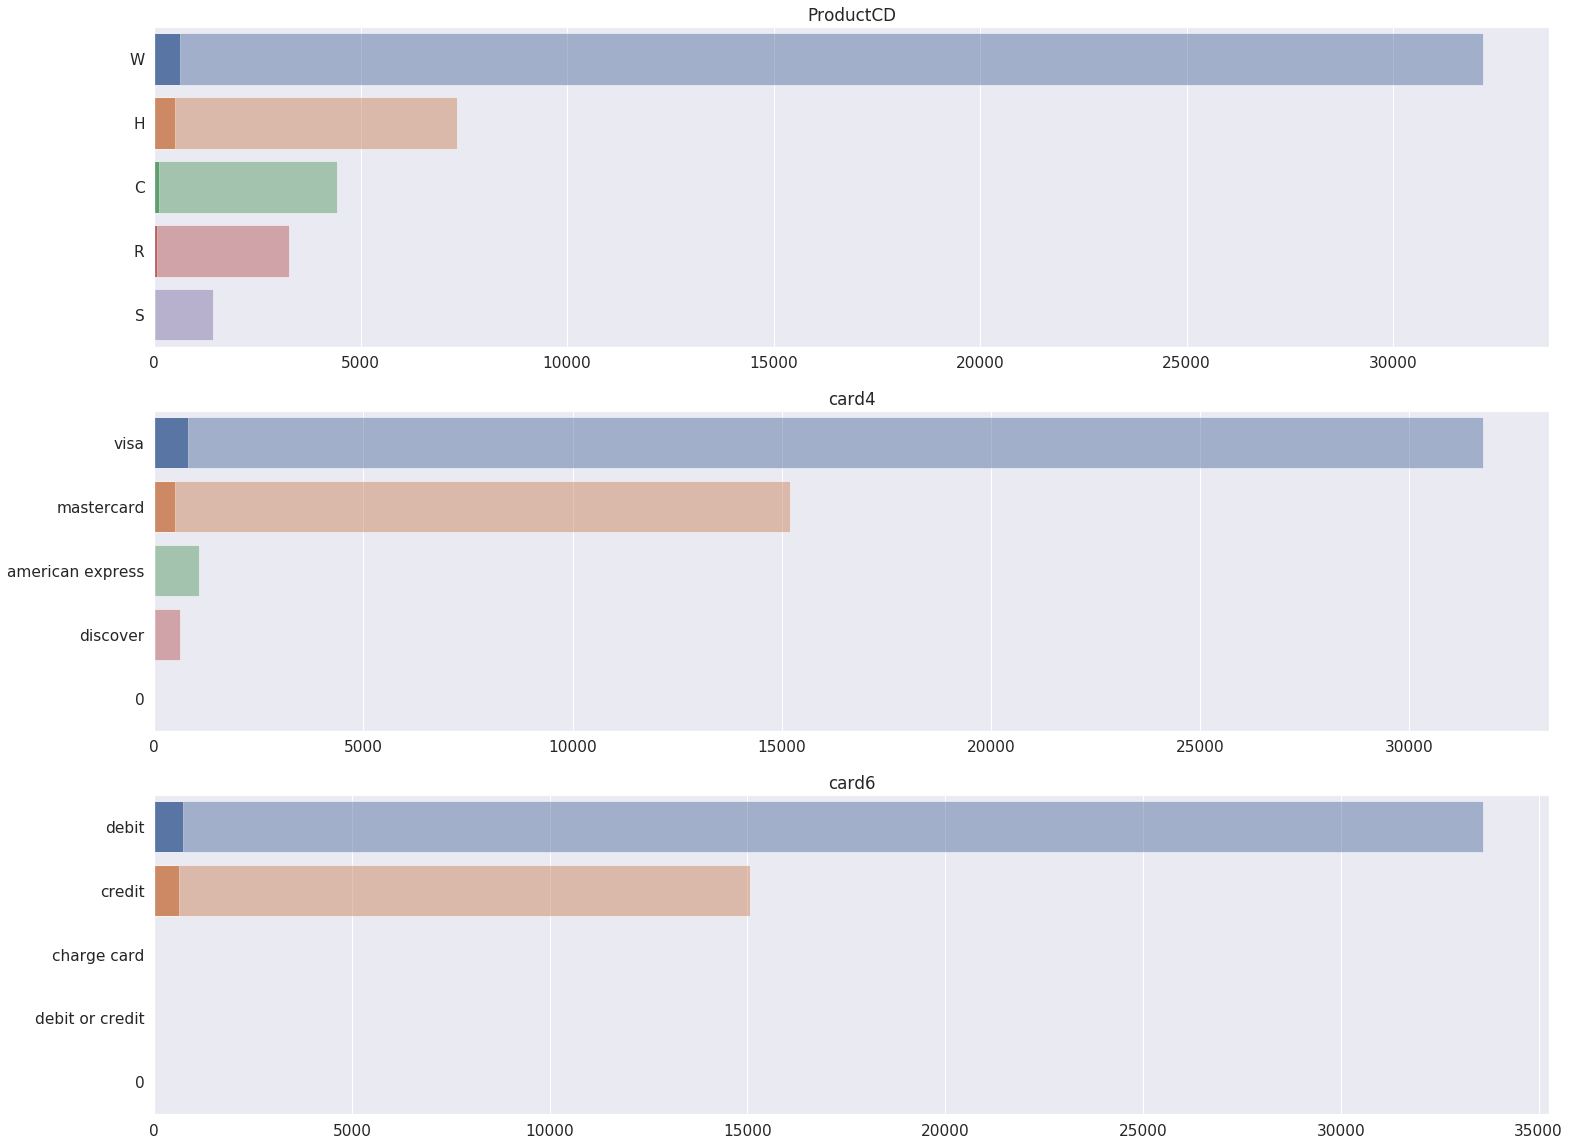

In [43]:
sns.set(font_scale=1.4)
plt.figure(figsize=(25,20))

for i, colname in enumerate(['ProductCD', 'card4', 'card6']):
    plt.subplot(3,1,i+1)
    plt.title(colname)
    
    val_counts_t1 = train.loc[train['isFraud'] == 1, colname].value_counts()
    val_counts_t0 = train.loc[train['isFraud'] == 0, colname].value_counts()
    
    sns.barplot(val_counts_t1.values, val_counts_t1.index)
    sns.barplot(val_counts_t0.values, val_counts_t0.index, alpha=0.5)
    
plt.show()

### Основное задание:

Даны выборки для обучения и для тестирования. Задание заключается в том, чтобы попробовать разные способы валидации, проанализировать плюсы / минусы каждой и сделать выводы о том, какой способ валидации наиболее устойчивый в данной задаче. Метрика качества для оценки прогнозов - ROC-AUC, название целевой переменной - IsFraud. Рекомендуется использовать модели градиетного бустинга, реализация любая.

### Задание 1:

сделать Hold-Out валидацию с разбиением, размер которого будет адеквтаным, по вашему мнению; разбиение проводить по id-транзакции (TransactionID), обучать модель градиетного бустинга любой реализации с подбором числа деревьев по early_stopping критерию до достижения сходимости. Оценить качество модели на тестовой выборке, оценить расхождение по сравнению с качеством на обучающей выборке и тестовой выборке.

In [44]:
X, y = train.copy().sort_values(by='TransactionID')[
    quant_feats + cat_feats + list(num_feats)
], train.copy().sort_values(by='TransactionID')['isFraud']

X_train, y_train, X_test, y_test = X[:45000], y[:45000], X[45001:], y[45001:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45000, 198), (45000,), (5000, 198), (5000,))

In [45]:
%%time
model = CatBoostClassifier(early_stopping_rounds=10,
                           loss_function='Logloss',
                           cat_features=cat_feats,
                          silent=True)

model.fit(X_train, y_train)

CPU times: user 2min 43s, sys: 10.2 s, total: 2min 53s
Wall time: 16.3 s


In [46]:
preds_probas = model.predict_proba(X_test)
roc_auc_score(y_test, preds_probas[:,1])

0.8868248479212677

In [47]:
preds_probas = model.predict_proba(test[quant_feats + cat_feats + list(num_feats)])
roc_auc_score(test['isFraud'], preds_probas[:,1])

0.8649200870219194

### Задание 2:

сделать Hold-Out валидацию с разбиением на 3 выборки, разбиение проводить по id-транзакции (TransactionID), размер каждой выборки подобрать самостоятельно. Повторить процедуру из п.1.

In [48]:
X_train, y_train, X_val, y_val, X_test, y_test = X[:40000], y[:40000], X[40001:45000], y[40001:45000], X[45001:], y[45001:]

In [49]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((40000, 198), (40000,), (4999, 198), (4999,), (5000, 198), (5000,))

In [50]:
%%time
model = CatBoostClassifier(early_stopping_rounds=10,
                           loss_function='Logloss',
                           cat_features=cat_feats,
                          silent=True)

model.fit(X_train, y_train)

CPU times: user 2min 27s, sys: 9.32 s, total: 2min 36s
Wall time: 14.5 s


In [51]:
preds_probas = model.predict_proba(X_test)
roc_auc_score(y_test, preds_probas[:,1])

0.8409542213956372

In [52]:
preds_probas = model.predict_proba(X_val)
roc_auc_score(y_val, preds_probas[:,1])

0.9041938436892092

In [53]:
preds_probas = model.predict_proba(test[quant_feats + cat_feats + list(num_feats)])
roc_auc_score(test['isFraud'], preds_probas[:,1])

0.8576922253125421

Качество на тестовых данных выросло

### Задание 3:

построить доверительный интервал на данных из п.2 на основе бутстреп выборок, оценить качество модели на тестовом выборке относительно полученного доверительного интервала. Сделать выводы.

In [54]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx

def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [55]:
np.random.seed(42)
scores = create_bootstrap_metrics(y_val, model.predict_proba(X_val)[:, 1], roc_auc_score)

calculate_confidence_interval(scores)

(0.8683059909766779, 0.9361421235990817)

In [56]:
np.random.seed(42)
scores = create_bootstrap_metrics(y_test, model.predict_proba(X_test)[:, 1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7838627260456978, 0.897946565709589)

In [57]:
np.random.seed(42)
scores = create_bootstrap_metrics(test['isFraud'], model.predict_proba(
    test[quant_feats + cat_feats + list(num_feats)])[:, 1], roc_auc_score)

calculate_confidence_interval(scores)

(0.8471434211121998, 0.86762281260261)

Доверительный интервал на тесте небольшой, и предыдущие оценки попадают в него, таким образом, можно сказать, что модель предсказывает нормально.

### Задание 4:

выполнить Adversarial Validation на основе данных из обучения / теста, подобрать объема из обучающей выборки, которые сильно похожи на объекты из тестовой выборки, и использовать их в качестве валидационного набора. Сделать выводы о полученных результатах.

In [58]:
y_train = train['isFraud'].copy()
X_train = train[quant_feats + cat_feats + list(num_feats)].copy()

y_test = test['isFraud'].copy()
X_test = test[quant_feats + cat_feats + list(num_feats)].copy()

In [59]:
x_adv = pd.concat([
    X_train, X_test], axis=0)
y_adv = np.hstack((np.zeros(X_train.shape[0]), np.ones(X_test.shape[0])))
assert x_adv.shape[0] == y_adv.shape[0]

In [60]:
%%time
model = CatBoostClassifier(n_estimators=5, cat_features=cat_feats)
model.fit(x_adv, y_adv)

Learning rate set to 0.5
0:	learn: 0.5703958	total: 51.2ms	remaining: 205ms
1:	learn: 0.5400792	total: 104ms	remaining: 156ms
2:	learn: 0.5309998	total: 134ms	remaining: 89.1ms
3:	learn: 0.5271759	total: 156ms	remaining: 38.9ms
4:	learn: 0.5193621	total: 180ms	remaining: 0us
CPU times: user 3.74 s, sys: 155 ms, total: 3.89 s
Wall time: 643 ms


In [61]:
y_pred = model.predict_proba(X_train)

In [62]:
pd.cut(
    y_pred[:, 1], bins=np.arange(0, 1.01, 0.1)
).value_counts().sort_index()

(0.0, 0.1]     8413
(0.1, 0.2]     5427
(0.2, 0.3]     1637
(0.3, 0.4]     2226
(0.4, 0.5]     3326
(0.5, 0.6]    12528
(0.6, 0.7]     9835
(0.7, 0.8]     5554
(0.8, 0.9]      555
(0.9, 1.0]      500
dtype: int64

In [63]:
train['proba'] = y_pred[:, 1]
train_like_test = train.loc[train['proba'] > 0.5]

y_train = train_like_test['isFraud']
X_train = train_like_test[quant_feats + cat_feats + list(num_feats)]

In [64]:
%%time
model = CatBoostClassifier(early_stopping_rounds=10,
                           loss_function='Logloss',
                           cat_features=cat_feats,
                          silent=True)

model.fit(X_train, y_train)

CPU times: user 1min 56s, sys: 6.61 s, total: 2min 3s
Wall time: 11.2 s


In [65]:
preds_probas = model.predict_proba(X_test)
roc_auc_score(y_test, preds_probas[:,1])

0.86077017470945

Результат попал почти по нижней границе доверительного интервала

### Задание 4:

сделать KFold / StratifiedKFold валидацию (на ваше усмотрение), оценить получаемые качество и разброс по метрике качества. Сделать выводы об устойчивости кросс-валидации, сходимости оценки на кросс-валидации и отложенном наборе данных;

In [66]:
y_train = train['isFraud'].copy()
X_train = train[quant_feats + cat_feats + list(num_feats)].copy()

y_test = test['isFraud'].copy()
X_test = test[quant_feats + cat_feats + list(num_feats)].copy()

In [67]:
model = CatBoostClassifier(early_stopping_rounds=10,
                           loss_function='Logloss',
                           cat_features=cat_feats,
                          silent=True)

In [68]:
%%time
cv = cross_val_score(
    estimator=model,
    X=X_train,
    y=y_train,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)

print(f"CV-results: {round(np.mean(cv), 4)} +/- {round(np.std(cv), 3)}")

CV-results: 0.886 +/- 0.019
CPU times: user 1.04 s, sys: 245 ms, total: 1.28 s
Wall time: 1min 28s


С выводами туго. Но вроде как кросс-валидация показала хороший результат с небольшими отклонениями, и является лучшим решением